# One-dimensional wave propagation

\begin{align}
    \rho \frac{\partial^2 \delta}{\partial t^2} = \frac{\partial}{\partial x} \left( \mu \frac{\partial \delta}{\partial x} \right) + f
\end{align}

\begin{align}
    \rho \frac{\partial v}{\partial t} &=  \frac{\partial \tau}{\partial x} + f \\
    \frac{\partial \tau}{\partial t} &= \mu \frac{\partial v}{\partial x} \\
    v &= \frac{\partial \delta}{\partial t}
\end{align}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
μ0 = 30e3                #shear modulus (MPa)
c0 = 3.0                 #shear wave speed (km/s)
ρ0 = μ0 / (c0**2)        #density (kg/m^3)
print(f"ρ0 = {ρ0:.2e} kg/m^3")

ρ0 = 3.33e+03 kg/m^3


### Define grid points

In [3]:
NX = 80                 ## number of grid points
NT = 1500               ## number of time steps
Δt = 1.0/NT             ## time step
Δx = 1.0/NX             ## grid spacing
NB = 30                 ## absorbing boundary
N = NX + 2 * NB + 1     ## total grid points
xv = np.arange(0, N) * Δx - NB * Δx
xτ = (xv[1:] + xv[:-1]) / 2.0 ## staggered grid


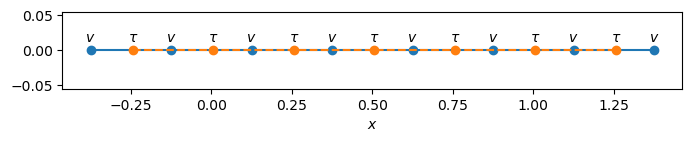

In [4]:
fig, ax = plt.subplots(figsize=(8, 1))
ax.plot(xv[::20], np.zeros_like(xv)[::20], 'o-')
ax.plot(xτ[10::20], np.zeros_like(xτ)[10::20], 'o--')
for i in range(0, N, 20):
    ax.text(xv[i], 0.008, r'$v$', ha='center', va='bottom')
for i in range(10, N, 20):
    ax.text(xτ[i], 0.008, r'$\tau$', ha='center', va='bottom')
ax.set_xlabel(r'$x$')
plt.show()

### Define absorbing boundary conditions

In [5]:
C = 1000.0
cv = np.zeros(N)
for i in range(NB+1):
    d = i * Δx
    cv[NB + NX + i] = C * (d / (NB * Δx)) ** 3
    cv[NB - i] = C * (d / (NB * Δx)) ** 3

cτ = np.zeros(N-1)
for i in range(NB):
    d = (i + 0.5) * Δx
    cτ[NB + NX + i] = C * (d / (NB * Δx)) ** 3
    cτ[NB - i -1] = C * (d / (NB * Δx)) ** 3


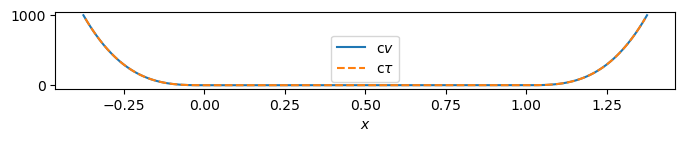

In [6]:
fig, ax = plt.subplots(figsize=(8, 1))
ax.plot(xv, cv, ls='-',label=r'c$v$')
ax.plot(xτ, cτ, ls='--', label=r'c$\tau$')
ax.legend()
ax.set_xlabel(r'$x$')
plt.show()

### Define source function

In [7]:
def source(Δt, f0 = 5.0):
    t = np.arange(-1.0/f0, 1.0/f0, Δt)
    b = (np.pi * f0 * t) ** 2 
    # return (1.0 - 2.0 * b) * np.exp(-b) ## Ricker
    return np.exp(-b) ## Gaussian

f = source(Δt) * 1e4
if len(f) < NT:
    f = np.pad(f, (0, NT - len(f)), 'constant')

## source location
mask = np.zeros(N-2)
mask[NB + 1] = 1.0

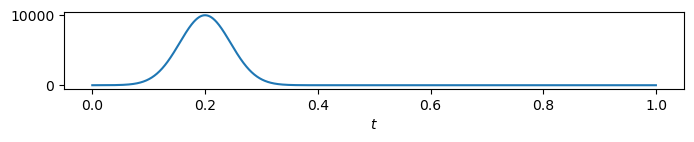

In [8]:
fig, ax = plt.subplots(figsize=(8, 1))
ax.plot(np.arange(NT) * Δt, f)
ax.set_xlabel(r'$t$')
plt.show()

### Conduct finite difference time stepping

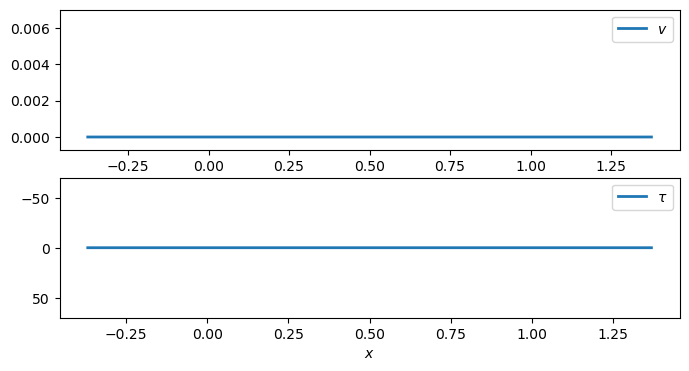

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
v = np.zeros(N)
τ = np.zeros(N-1)

ρ = np.ones(N-2) * ρ0
μ = np.ones(N-1) * μ0

τ_hist = []
v_hist = []
vmax = 0.007
τmax = -70

for i in range(NT):

    Δv = 1.0/ρ * ((τ[1:]-τ[:-1])/Δx  + f[i] * mask) - cv[1:-1]*v[1:-1]
    v[1:-1] += Δv * Δt

    Δτ = μ * (v[1:]-v[:-1])/Δx - cτ*τ
    τ += Δτ * Δt

    τ_hist.append(τ.copy())
    v_hist.append(v.copy())

    if i % 100 == 0:
        [axi.clear() for axi in ax.ravel()]
        ax[0].plot(xv, v, lw=2, label=r'$v$')
        ax[0].set_ylim(-vmax/10, vmax)
        ax[0].set_xlabel(r'$x$')
        ax[0].legend()
        ax[1].plot(xτ, τ, lw=2, label=r'$\tau$')
        ax[1].set_ylim(-τmax, τmax)
        ax[1].set_xlabel(r'$x$')
        ax[1].legend()
        display(fig)
        clear_output(wait=True)

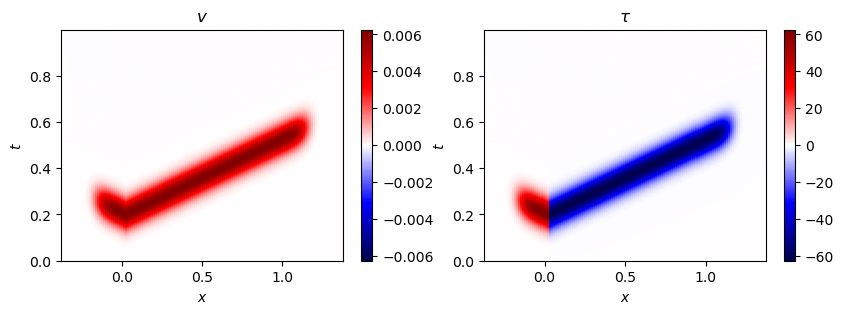

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
vmax = np.max(np.abs(v_hist))
im = ax[0].pcolormesh(xv, np.arange(NT)*Δt, np.array(v_hist), vmin=-vmax, vmax=vmax, cmap='seismic', shading='nearest', rasterized=True)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$t$')
ax[0].set_title(r'$v$')
fig.colorbar(im, ax=ax[0])
vmax = np.max(np.abs(τ_hist))
im = ax[1].pcolormesh(xτ, np.arange(NT)*Δt, np.array(τ_hist), vmin=-vmax, vmax=vmax, cmap='seismic', shading='nearest', rasterized=True)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')
ax[1].set_title(r'$\tau$')
fig.colorbar(im, ax=ax[1])
plt.show()